### Alunos
- Alexandre Candido Souza
- Klarissa Andrade de Morais

# Introdução

In [711]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import math
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import sklearn.metrics as sklearn_metrics
from scipy.spatial import distance



plt.style.use('default')

trainData = pd.read_csv('./input/titanic_unsupervised.csv',index_col=0)


Os dados seguiam o seguinte formato:

| Variável | Definição | Valores |
|---|---|---|
| Pclass | Classe do Bilhete | 1 \| 2 \| 3 |
| Sex | Sexo | "male" \| "female" |
| Age | Idade | Anos (fracional se menor que 1)|
| Sibsp | Qtd de irmãos/conjugues a bordo |  |
| Parch | Qtd de pais/filhos a bordo |  |
| Ticket | Numero do Ticket |  |
| Fare | Taxa de passagem |  |
| Cabin | Numero da Cabine |  |
| Embarked | Porto de Embarque | C = Cherbourg, Q = Queenstown, S = Southampton |

Percebemos que háviam muitas idades inválidas. É importante saber quantas e se outras colunas também estavam com dados faltando, e se for o caso, trata-los

In [712]:
print("Training DataSet:")
print(trainData.isna().sum())

Training DataSet:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Usamos o `InterativeImputer` do `Scikit`, que basicamente tenta aproximar o valor que está faltando na coluna idade à partir das outras 2 colunas, iterando recursivamente até chegar em um valor que talvez seja próximo do valor real, podemos parametrizar ele mais, mas deixamos no comportamento padrão.  
> Existem outros métodos de se imputar valores como o `SimpleImputer`, ou simplesmente tentar fazer uma média, moda ou mediana para preencher os valores que estão faltando. Mas no nosso caso o InterativeImputer funcionou bem.

qtd de idades inválidas: 0


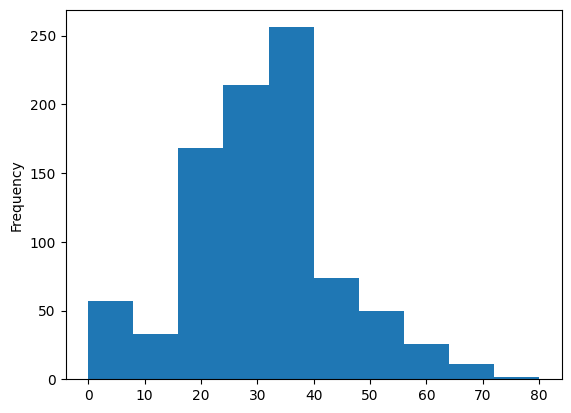

In [713]:
columns = ["SibSp", "Parch", "Age"]
imputer = IterativeImputer(min_value = 0)

imputedValues = imputer.fit_transform(trainData[columns])
correctedValues = pd.DataFrame(imputedValues, columns=columns)
trainData["Age"] = correctedValues["Age"]

trainData["Age"].plot(kind='hist')
print(f"qtd de idades inválidas: {trainData['Age'].isna().sum()}")

Para conseguir plotar o gráfico corretamnete, tem algumas colunas que precisam ser modificadas, pois não estão em valores númericos

In [714]:
#Valores faltando na taxa de embarque => média
trainData["Fare"] = trainData["Fare"].replace(np.NaN, trainData["Fare"].mean())
#converter em valores numéricos
trainData["Sex"] = trainData["Sex"].map({"male": 0, "female": 1})
trainData["Embarked"] = trainData["Embarked"].map({"C": 0, "Q": 1, "S": 2})

#removo qualquer NaN remanescente.
trainData = trainData.dropna().reset_index(drop=True)
trainData = trainData.drop(["Name", "Ticket", "Cabin", "PassengerId"], axis=1)
trainData.describe()


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000
mean,1.198020,0.470297,35.254141,0.445545,0.440594,76.103301,1.297030
std,0.528205,0.500357,14.955741,0.630490,0.732294,74.759941,0.946789
min,1.000000,0.000000,0.920000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,25.000000,0.000000,0.000000,28.959375,0.000000
50%,1.000000,0.000000,33.500000,0.000000,0.000000,55.000000,2.000000
75%,1.000000,1.000000,46.750000,1.000000,1.000000,89.776050,2.000000
max,3.000000,1.000000,80.000000,3.000000,4.000000,512.329200,2.000000


In [715]:
#Criamos essa coluna temporaria "FamilyCount" somando a qtd de filhos e de conjugues ao passageiro
#O dado mais relevante é saber se o passageiro está sozinho ou não.
trainData["FamilyCount"] = trainData['SibSp'] + trainData['Parch'] + 1
trainData['IsAlone'] = trainData["FamilyCount"] == 1

trainData = trainData.drop(["SibSp","Parch"], axis=1)

## Visualizando a Distribuição dos Dados
Após todos os processos de tratamento e normalização dos dados, temos o dataset final a ser utilizado pelo algoritmo. Agora, iremos visualizar brevemente a nova distribuição dos dados de custo que foram mapeados:

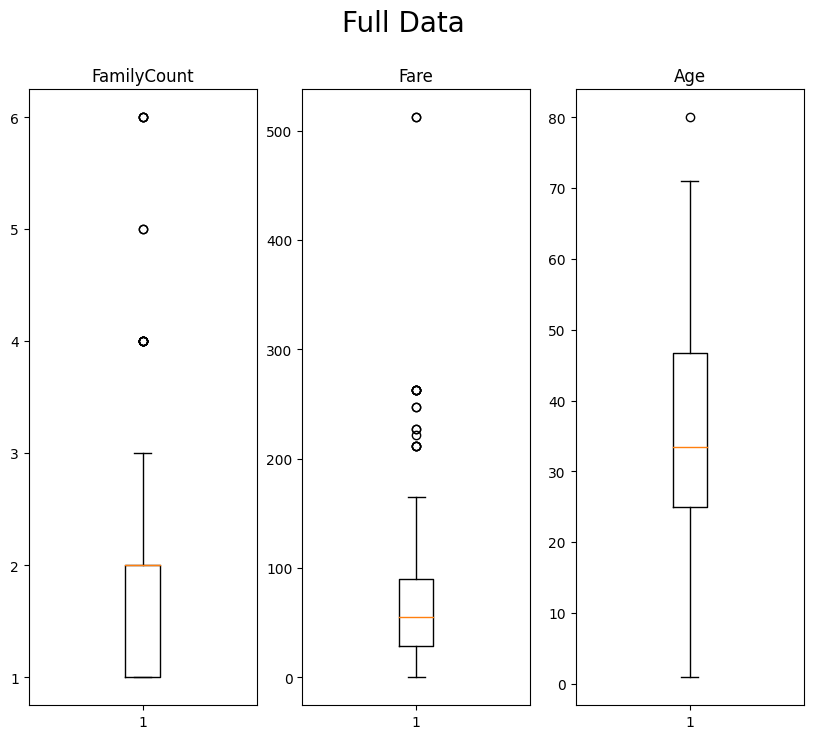

In [716]:
params = ["FamilyCount", "Fare", "Age"]
count = len(params)
width = 3
height = int(count/width)
figure, axis = plt.subplots(height, width, figsize=(10, 8))
figure.suptitle("Full Data", fontsize=20)

for i,attr in enumerate(params):
    values = trainData[attr].astype(float)
    axis[i].boxplot(values)
    axis[i].set_title(attr)

plt.show()

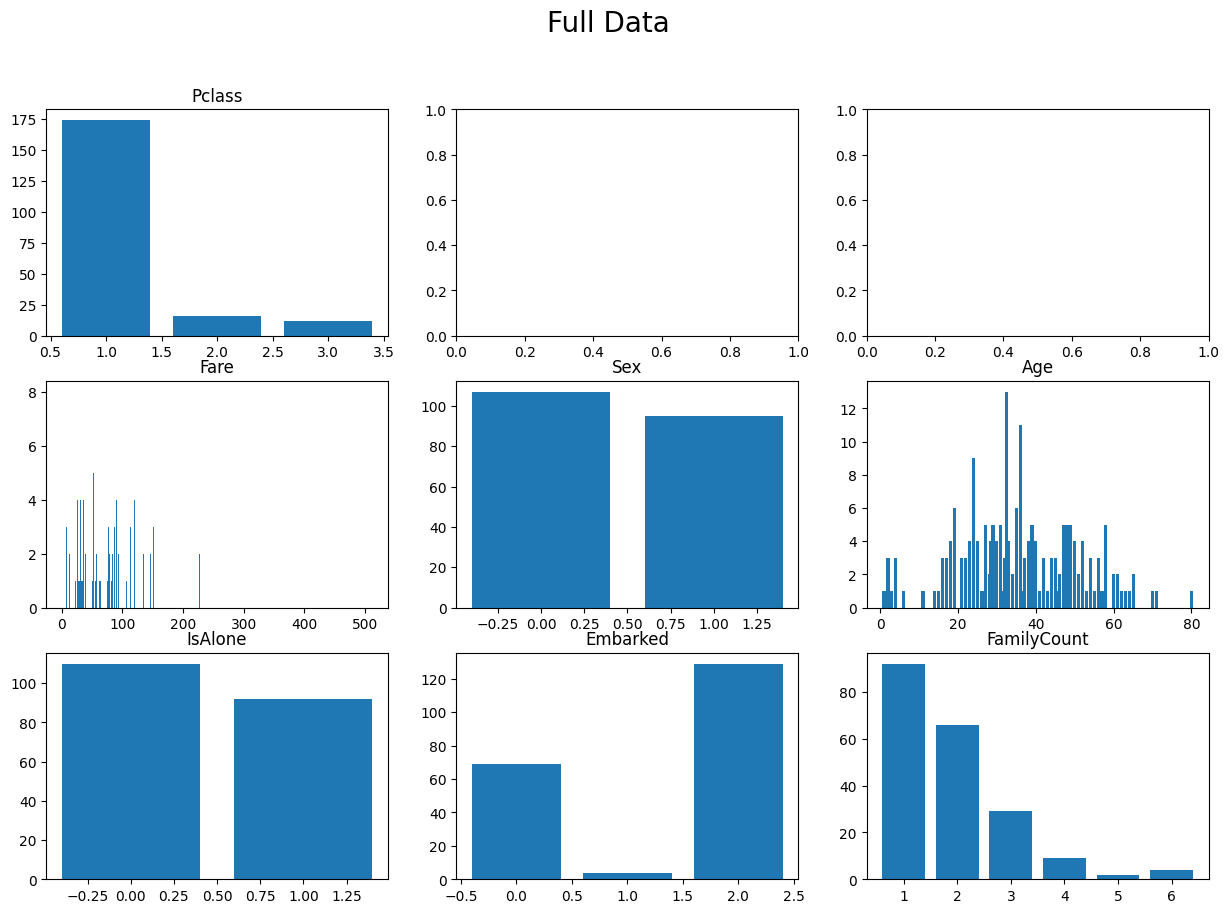

In [717]:
count = len(trainData.columns)
width = 3
figure, axis = plt.subplots(int(np.ceil(count/width)), width, figsize=(15, 10))
figure.suptitle("Full Data", fontsize=20)

for i,attr in enumerate(trainData.columns):
    x,y = [int(np.ceil(i/width)), int(np.ceil(i % width))]
    labels = trainData[attr].astype(float).unique()
    labels.sort()
    values = trainData[attr].value_counts().sort_index()
    axis[x,y].bar(labels, values)
    axis[x,y].set_title(attr)

plt.show()


## Normalizando os dados
Normalizamos os dados do Dataset, visto que esses algoritmos de clusterização dependem fortemente da distância entre os pontos de dadods para determinar os clusters e, por consequência, são extremamente sensíveis a dados com valores extremamente distintos. Ter as características dos dados com escalas muito diferentes acaba fazendo com que a distância calculada possa ser dominada pelas características com maiores valores absolutos.

Ao normalizar os dados, as características são transformadas em escala comum, como pode ser visto abaixo, garantindo que cada um contribua igualmente para a distância entre os pontos dados:

In [718]:
trainData = pd.DataFrame(normalize(trainData, axis=0), columns=trainData.columns)
trainData.head()

,Pclass,Sex,Age,Fare,Embarked,FamilyCount,IsAlone
0,0.053760,0.102598,0.069844,0.047071,0.000000,0.064718,0.000000
1,0.053760,0.102598,0.064330,0.035064,0.087706,0.064718,0.000000
2,0.053760,0.000000,0.099251,0.034247,0.087706,0.032359,0.104257
3,0.161281,0.102598,0.007352,0.011028,0.087706,0.097078,0.000000
4,0.053760,0.102598,0.106603,0.017532,0.087706,0.032359,0.104257


## K-Means

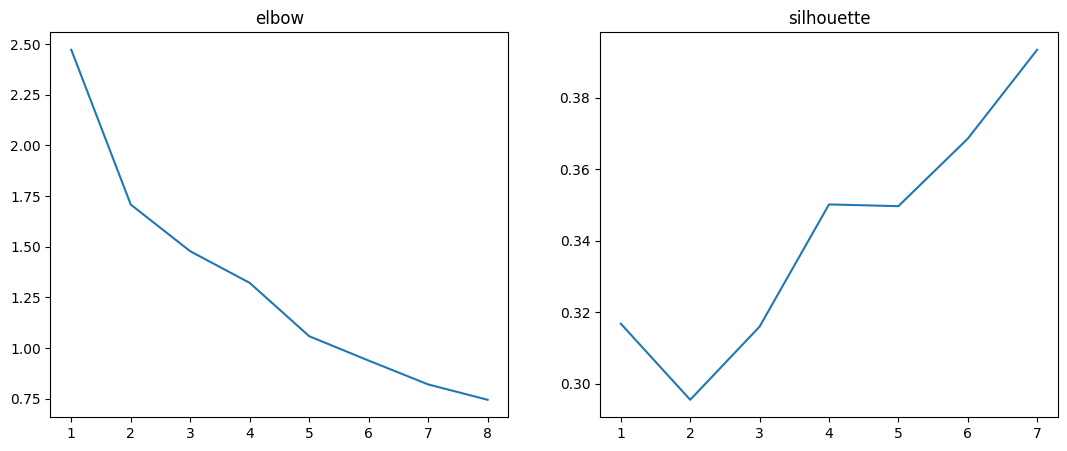

In [719]:
kRange = list(range(1,9))
scores = {"elbow": [], "silhouette": []}

for i in kRange:
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(trainData)
  scores["elbow"].append(kmeans.inertia_)
  if(i == 1): continue
  scores["silhouette"].append(sklearn_metrics.silhouette_score(trainData, kmeans.labels_))

fig, ax = plt.subplots(1,2,figsize=(13, 5))
for i,(k,v) in enumerate(scores.items()):
  ax[i].plot(range(1,len(v) + 1), v)
  ax[i].set_title(k)

plt.show()


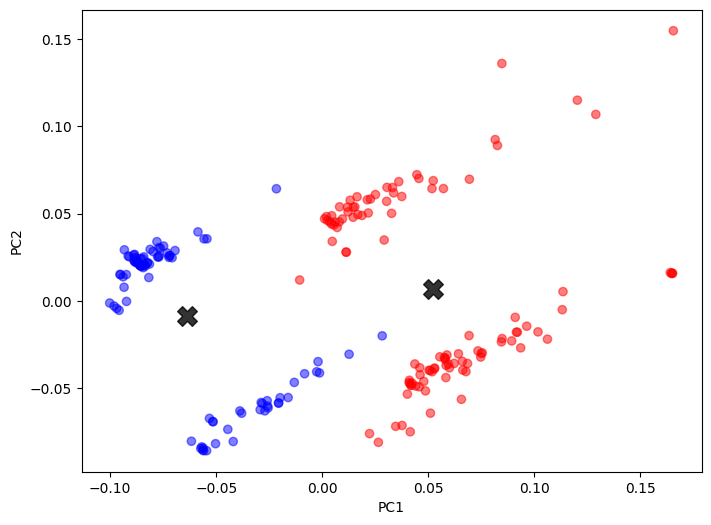

In [720]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(trainData)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(trainData.values)

fig, ax = plt.subplots(figsize=(8, 6))

colors = np.array(['red', 'blue'])
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=colors[kmeans.labels_], alpha=0.5)
ax.scatter(pca.transform(kmeans.cluster_centers_)[:, 0], pca.transform(kmeans.cluster_centers_)[:, 1],
           c='black', s=200, alpha=0.8, marker='X')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()